<a href="https://colab.research.google.com/github/iatra/COSC2673-Assignment2-Group9/blob/main/s4005248_s3980067.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning COSC2673-Assignment2-Group9
Author : Joelle Lee Ming Yin (s3980067) & Isabella Tranquilino (s4005248)

## Approach

### Load Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

zip_path = '/content/drive/MyDrive/ML A2 Dataset/Image_classification_data.zip'

import zipfile
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/data')

import os

# List first few files/folders in the extraction folder
extracted_path = '/content/data'
for root, dirs, files in os.walk(extracted_path):
    print(f"Directory: {root}")
    for file in files[:5]:  # Show up to 5 files per directory
        print(f"  - {file}")
    break  # Remove this if you want to see all subfolders


Mounted at /content/drive
Directory: /content/data
  - data_labels_mainData.csv
  - data_labels_extraData.csv


In [ ]:
import pandas as pd

df_main = pd.read_csv('/content/data/data_labels_mainData.csv')
df_extra = pd.read_csv('/content/data/data_labels_extraData.csv')

df_main.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0


### Class Imbalance Identification

In [ ]:
#--------- Check class imbalance in cellTypeName -------------
class_counts_named = df_main['cellTypeName'].value_counts()
print("Class distribution (by name):")
print(class_counts_named)

# Calculate percentage of each unique cell type
data = {'cellTypeName': ['epithelial'] * 4079 + ['inflammatory'] * 2543 + ['fibroblast'] * 1888 + ['others'] * 1386}
df_temp = pd.DataFrame(data)

class_percentages_named = df_temp['cellTypeName'].value_counts(normalize=True) * 100
print("Class distribution (by percentage):")
print(class_percentages_named.round(2))

Class distribution (by name):
cellTypeName
epithelial      4079
inflammatory    2543
fibroblast      1888
others          1386
Name: count, dtype: int64
Class distribution (by percentage):
cellTypeName
epithelial      41.22
inflammatory    25.70
fibroblast      19.08
others          14.01
Name: proportion, dtype: float64


Based on the numbers and percentages, we can identify a class imbalance present in the CellTypeName distribution. We can see that the proportion of each cell is not equal with the epithelial cell being the most frequent.

**Implication:**


1.   The Machine Learning model that we will train might be biased towards the epithelial cell type because it appears the most frequent. The ML model might predict this class more often than the others and it might not identify cell type right.
2.   The model might also struggle to learn characteristics of the minority classes such as 'Fibroblast' due to limited image examples during the training which can lead to low classification scores.




In [ ]:
#--------- Check class imbalance in isCancerous -------------
print("Main Data - isCancerous distribution:")
print(df_main['isCancerous'].value_counts())

# Calculate percentage of isCancerous
main_data = {'isCancerous': [0] * 5817 + [1] * 4079}
df_main_temp = pd.DataFrame(main_data)

main_percentages = df_main_temp['isCancerous'].value_counts(normalize=True) * 100
print("Main Data - isCancerous distribution (by percentage):")
print(main_percentages.round(2))

#--------- Check class imbalance in isCancerous - extra Data -------------
print("Extra Data - isCancerous distribution:")
print(df_extra['isCancerous'].value_counts())

# Calculate percentage of isCancerous - extra Data
class_percentages_extra = df_extra['isCancerous'].value_counts(normalize=True) * 100
print("\nExtra Data - isCancerous distribution (by percentage):")
print(class_percentages_extra.round(2))

Main Data - isCancerous distribution:
isCancerous
0    5817
1    4079
Name: count, dtype: int64
Main Data - isCancerous distribution (by percentage):
isCancerous
0    58.78
1    41.22
Name: proportion, dtype: float64
Extra Data - isCancerous distribution:
isCancerous
0    7394
1    2990
Name: count, dtype: int64

Extra Data - isCancerous distribution (by percentage):
isCancerous
0    71.21
1    28.79
Name: proportion, dtype: float64


Not a drastic change in class imbalance for the main data but for the extra data shows a more significant class imbalance, the non-cancerous class has a larger representation than the cancerous class.

In [ ]:
#--------- Check class imbalance in cellType -------------
class_counts = df_main['cellType'].value_counts().sort_index()
print("Class distribution (by numeric label):")
print(class_counts)

# Calculate percentage of cellType
data_numeric = {'cellType': [0] * 1888 + [1] * 2543 + [2] * 4079 + [3] * 1386}
df_numeric = pd.DataFrame(data_numeric)

class_percentages_numeric = df_numeric['cellType'].value_counts(normalize=True) * 100
print("Class distribution (by percentage):")
print(class_percentages_numeric.round(2).sort_index())

Class distribution (by numeric label):
cellType
0    1888
1    2543
2    4079
3    1386
Name: count, dtype: int64
Class distribution (by percentage):
cellType
0    19.08
1    25.70
2    41.22
3    14.01
Name: proportion, dtype: float64


*There*'s a noticeable class imbalance in the cellType distribution. Class 2 is almost 3 times larger than the Class 3.

#TODO please justify that the class imbalance graphs can be seen in the EDA plots

### Exploratory Data Analysis (EDA)
Some cells of code in this section have been retrieved from the Week 6 Lab and have been adapted to fit this task.

In [ ]:
#--------- Initial exploration into dataframe -------------
df_main.info()
df_main.describe()

#checking for missing vals
df_main.isnull().sum() #no missing labels in any cols

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9896 entries, 0 to 9895
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   InstanceID    9896 non-null   int64 
 1   patientID     9896 non-null   int64 
 2   ImageName     9896 non-null   object
 3   cellTypeName  9896 non-null   object
 4   cellType      9896 non-null   int64 
 5   isCancerous   9896 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 464.0+ KB


,0
InstanceID,0
patientID,0
ImageName,0
cellTypeName,0
cellType,0
isCancerous,0


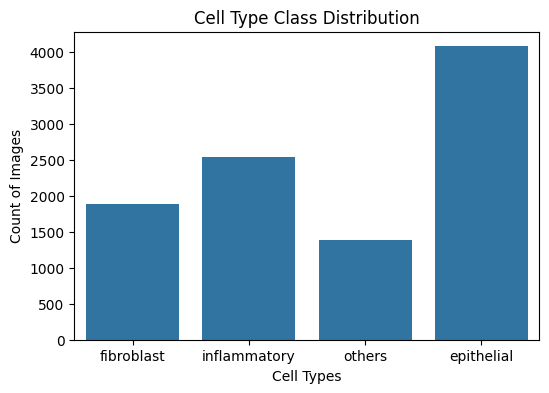

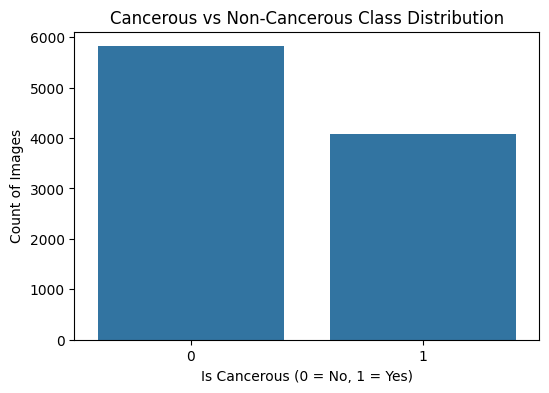

In [ ]:
#-------- Target variables class distributions ----------
df_main['cellTypeName'].value_counts()
df_main['isCancerous'].value_counts()

#plotting distributions
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.countplot(data=df_main, x='cellTypeName')
plt.xlabel('Cell Types')
plt.ylabel('Count of Images')
plt.title('Cell Type Class Distribution')
plt.show()

plt.figure(figsize=(6, 4))
sns.countplot(data=df_main, x='isCancerous')
plt.xlabel('Is Cancerous (0 = No, 1 = Yes)')
plt.ylabel('Count of Images')
plt.title('Cancerous vs Non-Cancerous Class Distribution')
plt.show()

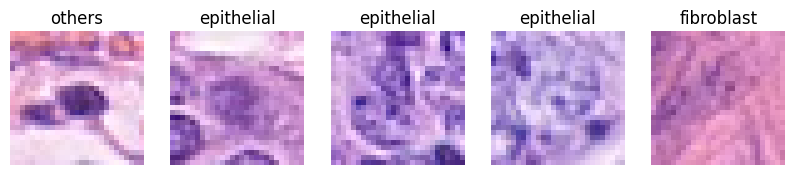

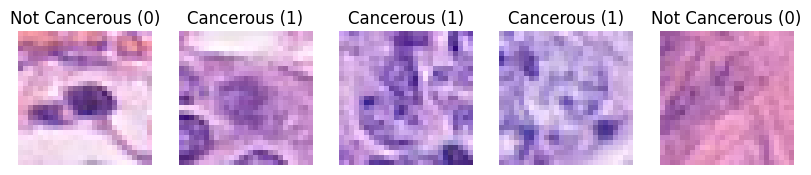

In [ ]:
# ------------- Displaying sample images --------------
import os
from PIL import Image

image_dir = '/content/data/patch_images/'

#grabbing 5 sample images
sample_images = df_main.sample(5)

#displaying sample images
f, axarr = plt.subplots(1, 5, figsize=(10, 5))
for i, (_, row) in enumerate(sample_images.iterrows()):
    img_path = os.path.join(image_dir, row['ImageName']) #accessing images from patch_images folder/dir
    img = Image.open(img_path)
    axarr[i].imshow(img)
    axarr[i].axis('off')
    axarr[i].set_title(row['cellTypeName'])  #display cell type names
plt.show()

f, axarr = plt.subplots(1, 5, figsize=(10, 5))
for i, (_, row) in enumerate(sample_images.iterrows()):
    img_path = os.path.join(image_dir, row['ImageName']) #accessing images from patch_images folder/dir
    img = Image.open(img_path)
    axarr[i].imshow(img)
    axarr[i].axis('off')
    cancer_identification = "Cancerous (1)" if row['isCancerous'] == 1 else "Not Cancerous (0)" #renaming label 1 or 0 to Cancerous or Not Cancerous
    axarr[i].set_title(cancer_identification)  #display isCancerous or Not
plt.show()


In [ ]:
#----------- Checking image sizes --------------
image_sizes = []

#checking through each image
for img_name in df_main['ImageName']:
    img_path = os.path.join(image_dir, img_name)
    try:
        with Image.open(img_path) as img:
            image_sizes.append(img.size)  #size of each image to list
    except:
        continue

print("Image sizes:")
for size in sorted(set(image_sizes)):
    print(size)

Image sizes:
(27, 27)


### Pre-processing of Data

In [ ]:
import numpy as np
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Add image path to DataFrame by creating a column to benefit adding images later
df_main['ImagePath'] = df_main['ImageName'].apply(lambda x: os.path.join(image_dir, x))

# Convert labels into one-hot encoded formats
y_isCancerous = to_categorical(df_main['isCancerous'].values, num_classes=2)
# Converted cell type labels to one-hot encoded formats 0,1,2,3
y_cellType = to_categorical(df_main['cellType'].values, num_classes=4)

##### Split into training, validation and test set

In [ ]:


# First Split - splitting into 80% for initial training X_train, and 20% test
# y_isCancerous into y1_train, y1_val, and y1_test @Isabella
# y_cellType into y2_train, y2_val, and y2_test @Joelle
# Split is based on isCancerous column to ensure the proportion of cancerous and non-cancerous samples is roughly the same in test and train sets. (Beneficial for potential class imbalance)
X_train, X_test, y1_train, y1_test, y2_train, y2_test = train_test_split(
    df_main['ImagePath'].values, y_isCancerous, y_cellType,
    test_size=0.2, stratify=df_main['isCancerous'], random_state=42
)

# Second Split - splitting the 80% further to 60% for training and the validation set to 20%
# Stratifying the split based on isCancerous labels in the training set to convert the one-hot encoded to its original 0 or 1 label. To ensure the validation set also has a good portion of the isCancerous classes.
X_train, X_val, y1_train, y1_val, y2_train, y2_val = train_test_split(
    X_train, y1_train, y2_train,
    test_size=0.25, stratify=np.argmax(y1_train, axis=1), random_state=42
)

##### Image loader with normalization

In [ ]:
def load_images(image_paths, target_size=(27, 27)):
    images = []
    for path in image_paths:
        img = cv2.imread(path)
        if img is None:
            continue
        img = cv2.resize(img, target_size)
        img = img.astype('float32') / 255.0  # normalize to [0, 1]
        images.append(img)
    return np.array(images)

#### Print train, validation and test shapes

In [ ]:
# Load image arrays
x_train = load_images(X_train) # 72 % of the original data
x_val = load_images(X_val) # 8% of the original data
x_test = load_images(X_test) # 20% of the original data

# Confirm shapes
print("x_train shape:", x_train.shape)
print("y1_train shape (isCancerous):", y1_train.shape)
print("y2_train shape (cellType):", y2_train.shape)

x_train shape: (7124, 27, 27, 3)
y1_train shape (isCancerous): (7124, 2)
y2_train shape (cellType): (7124, 4)


7124 samples in the training set
27x27 height and width of each image
3 RGB colours because the colour isnt grayscaled. The shapes are consistent after normalising to prepare for the classification tasks.

The following are ready for model training:

*   isCancerous prediction - y1_train
*   cellType prediction - y2_train
*   validation models - x_val, y1_val, y2_val
*   final evaluation - x_tests, y1_test, y2_test  


### Task 1: Classifying Cancerous Cell or Not
**Author: Isabella**

#### Model Building (Baseline)

#### Model Training (Parameter Tuning)

#### Evaluation

### Task 2: Classifying Cell Type
**Author: Joelle**

#### Model Building (Baseline)

#### Model Training (Parameter Tuning)

#### Evaluation

## Ultimate Judgement

## Conclusion